## Dependencies

In [1]:
import json
from tweet_utility_scripts import *
from transformers import TFBertModel, BertConfig
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-bert-uncased-160/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-bert-uncased-160/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-bert-uncased-160/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-bert-uncased-160/fold_3.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-bert-uncased-160/fold_4.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-bert-uncased-160/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,36,35,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,46,8,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,14,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,75,13,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_valid.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_valid.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_valid.npy
fold_3/x_train.npy
fold_3/y_valid.npy


# Model parameters

In [3]:
tokenizer_path = database_base_path + 'vocab.txt'
base_path = '/kaggle/input/qa-transformers/bert/'

config = {
  "MAX_LEN": 160,
  "BATCH_SIZE": 16,
  "EPOCHS": 5,
  "LEARNING_RATE": 5e-5,
  "ES_PATIENCE": 1,
  "question_size": 3,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'bert-base-uncased-tf_model.h5',
  "config_path": base_path + 'bert-base-uncased-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [4]:
module_config = BertConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    token_type_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    
    base_model = TFBertModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})
    last_state = sequence_output[0]
    
    
    x_start = layers.Conv1D(1,1)(last_state)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Dense(MAX_LEN, activation='softmax', name='y_start')(x_start)   

    x_end = layers.Conv1D(1,1)(last_state)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Dense(MAX_LEN, activation='softmax', name='y_end')(x_end) 
    
    
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.CategoricalCrossentropy(), 
                  metrics=[metrics.CategoricalAccuracy()])
    
    return model

# Tokenizer

In [5]:
tokenizer = BertWordPieceTokenizer(tokenizer_path , lowercase=True)
tokenizer.save('./')

['./vocab.txt']

# Train

In [6]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    model = model_fn(config['MAX_LEN'])
    tb_callback = TensorBoard(log_dir='./')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)

    history = model.fit(list(x_train), list(y_train),
                    validation_data=(list(x_valid), list(y_valid)),
                    callbacks=[es, tb_callback],
                    epochs=config['EPOCHS'], 
                    batch_size=config['BATCH_SIZE'],
                    verbose=2).history
    history_list.append(history)

    # Save last epoch weights
    model.save_weights(model_path)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'start_fold_%d' % (n_fold+1)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'end_fold_%d' % (n_fold+1)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'start_fold_%d' % (n_fold+1)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'end_fold_%d' % (n_fold+1)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold+1)] = k_fold['end_fold_%d' % (n_fold+1)].astype(int)
    k_fold['start_fold_%d' % (n_fold+1)] = k_fold['start_fold_%d' % (n_fold+1)].astype(int)
    k_fold['end_fold_%d' % (n_fold+1)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold+1)].clip(0, k_fold['end_fold_%d' % (n_fold+1)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold+1)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold+1)], x['end_fold_%d' % (n_fold+1)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold+1)].fillna('', inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold+1)] = k_fold.apply(lambda x: jaccard(x['text'], x['prediction_fold_%d' % (n_fold+1)]), axis=1)



FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/5
21984/21984 - 515s - loss: 4.1130 - y_start_loss: 1.8254 - y_end_loss: 2.2876 - y_start_categorical_accuracy: 0.5647 - y_end_categorical_accuracy: 0.4484 - val_loss: 2.8963 - val_y_start_loss: 1.4205 - val_y_end_loss: 1.4765 - val_y_start_categorical_accuracy: 0.5802 - val_y_end_categorical_accuracy: 0.6128
Epoch 2/5
21984/21984 - 499s - loss: 2.6591 - y_start_loss: 1.3030 - y_end_loss: 1.3561 - y_start_categorical_accuracy: 0.6179 - y_end_categorical_accuracy: 0.6280 - val_loss: 2.5903 - val_y_start_loss: 1.2766 - val_y_end_loss: 1.3139 - val_y_start_categorical_accuracy: 0.6239 - val_y_end_categorical_accuracy: 0.6399
Epoch 3/5
21984/21984 - 498s - loss: 2.0019 - y_start_loss: 0.9979 - y_end_loss: 1.0040 - y_start_categorical_accuracy: 0.6870 - y_end_categorical_accuracy: 0.7080 - val_loss: 2.4398 - val_y_start_loss: 1.1869 - val_y_end_loss: 1.2523 - val_y_start_categorical_accuracy: 0.6394 - val_y_end_categorical_ac

In [7]:
# Compress logs dir
!tar -cvzf train.tar.gz train
!tar -cvzf validation.tar.gz validation

# Delete logs dir
if os.path.exists('/kaggle/working/train/'):
    shutil.rmtree('/kaggle/working/train/')
if os.path.exists('/kaggle/working/validation/'):
    shutil.rmtree('/kaggle/working/validation/')

train/
train/events.out.tfevents.1586977455.8191f87d45b5.profile-empty
train/events.out.tfevents.1586977440.8191f87d45b5.13.10693.v2
train/events.out.tfevents.1586981828.8191f87d45b5.13.220155.v2
train/events.out.tfevents.1586979634.8191f87d45b5.13.115424.v2
train/plugins/
train/plugins/profile/
train/plugins/profile/2020-04-15_19-04-15/
train/plugins/profile/2020-04-15_19-04-15/local.trace
train/plugins/profile/2020-04-15_19-40-48/
train/plugins/profile/2020-04-15_19-40-48/local.trace
train/plugins/profile/2020-04-15_20-17-21/
train/plugins/profile/2020-04-15_20-17-21/local.trace
validation/
validation/events.out.tfevents.1586977955.8191f87d45b5.13.48035.v2
validation/events.out.tfevents.1586982342.8191f87d45b5.13.257497.v2
validation/events.out.tfevents.1586980149.8191f87d45b5.13.152766.v2


# Model loss graph

Fold: 1


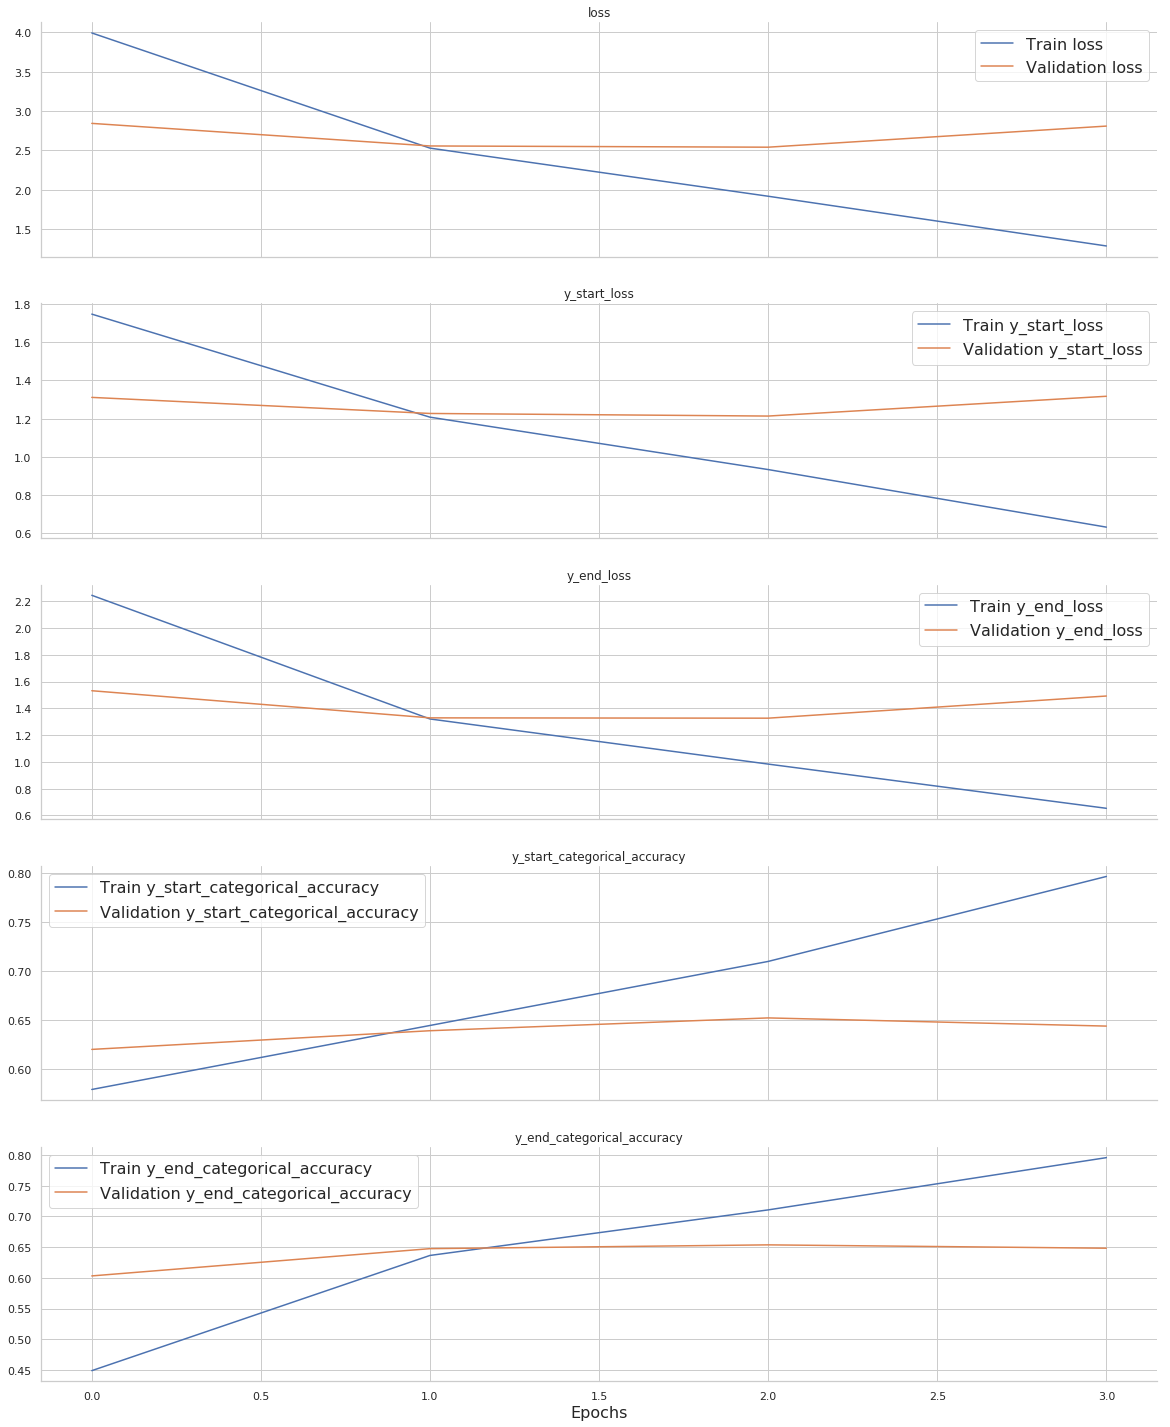

Fold: 2


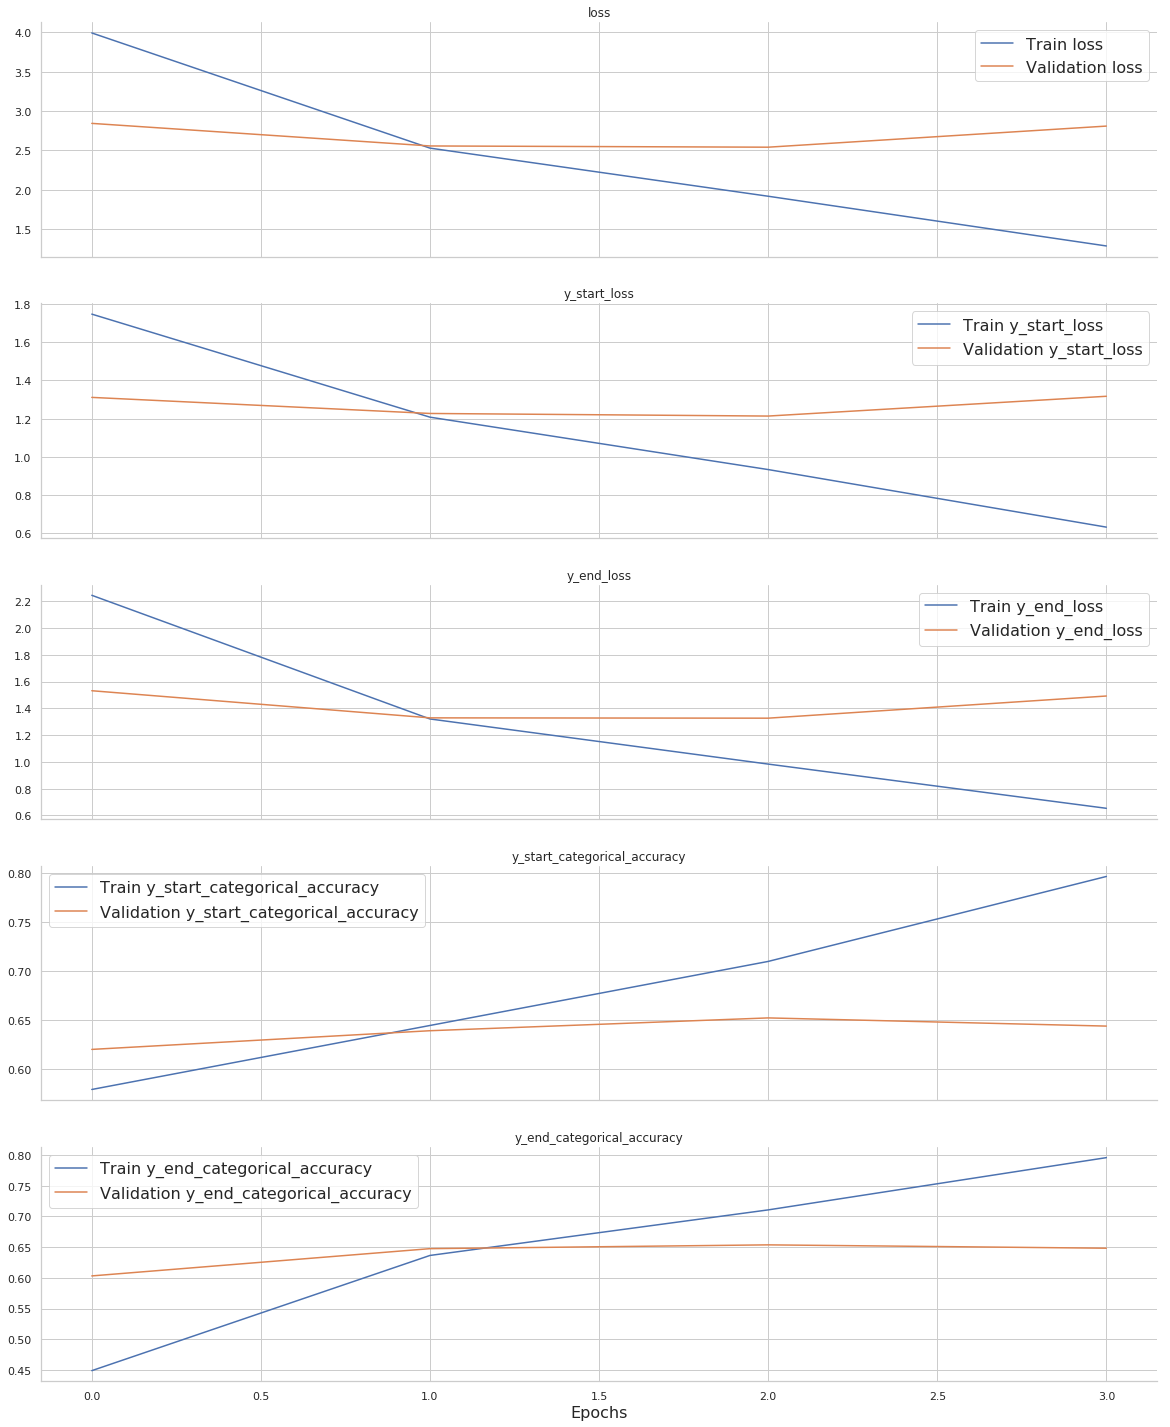

Fold: 3


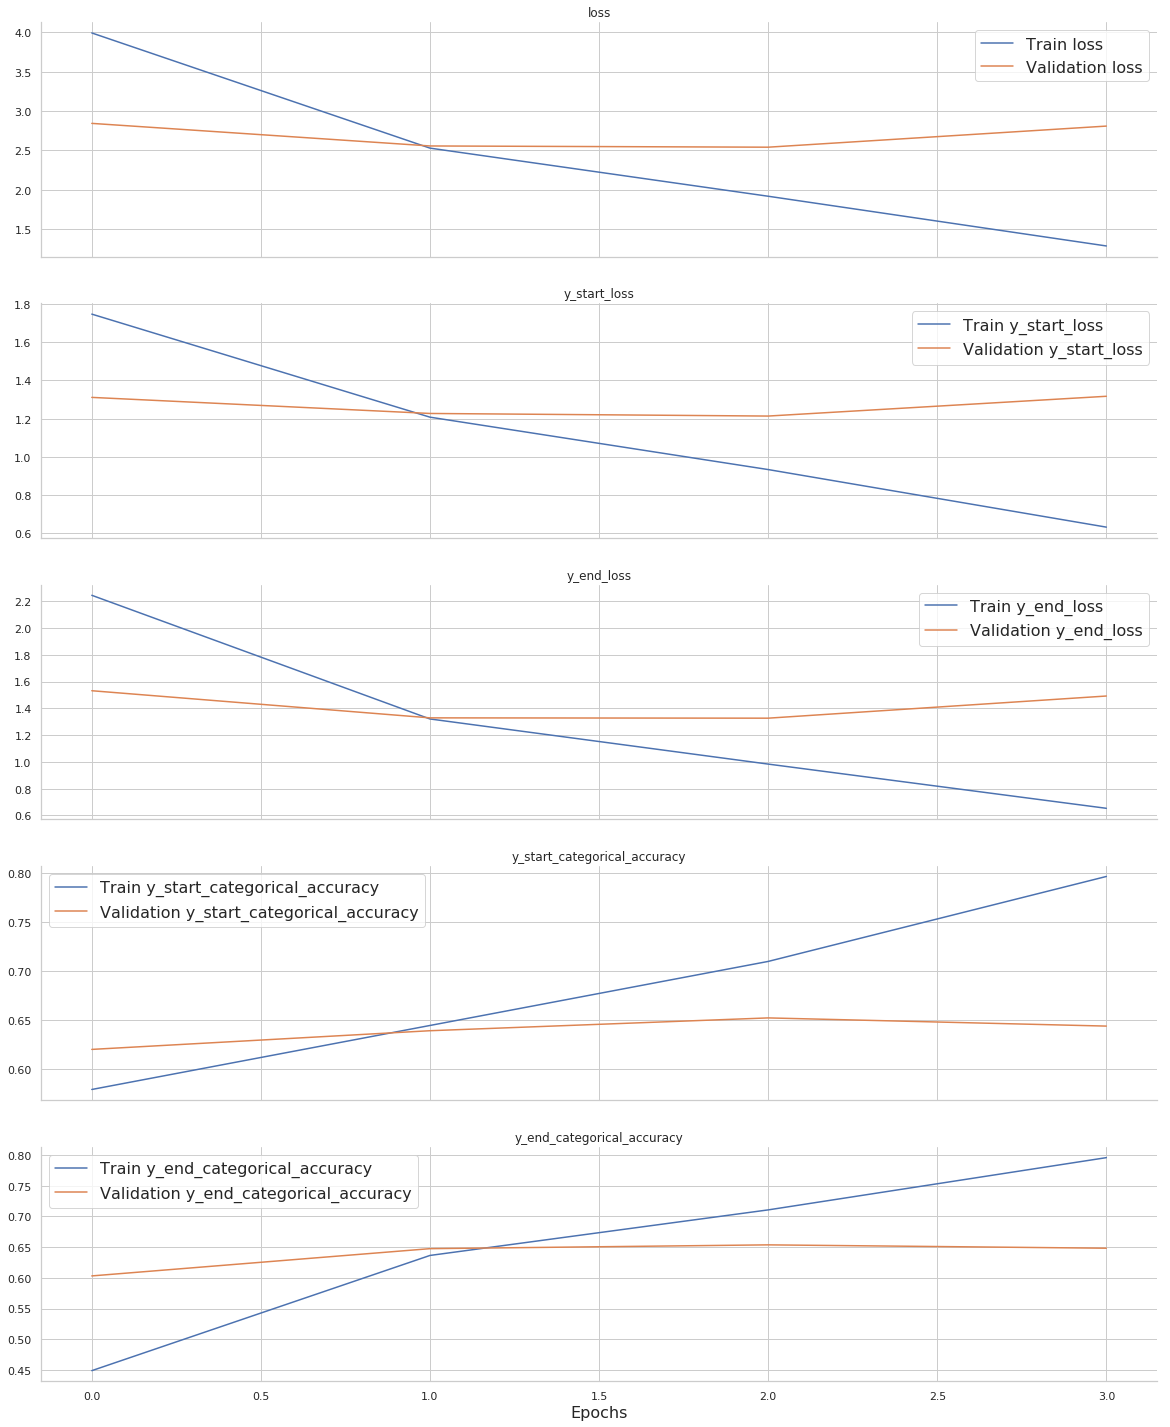

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history, metric_list=['loss', 'y_start_loss', 'y_end_loss', 
                                       'y_start_categorical_accuracy', 'y_end_categorical_accuracy'])

# Model evaluation

In [9]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.821673,0.658522,0.163151,0.815026,0.653961,0.826952,0.659297,0.82304,0.662307
Sentiment neutral,0.979109,0.972668,0.00644093,0.979107,0.972725,0.978903,0.971881,0.979316,0.973397
Sentiment negative,0.728401,0.440671,0.287731,0.712271,0.430296,0.737172,0.443341,0.735762,0.448375
Sentiment positive,0.702309,0.449017,0.253292,0.695669,0.443642,0.711538,0.449995,0.699721,0.453414
0 <= text < 10,0.914203,0.897031,0.0171722,0.915842,0.869919,0.9,0.943396,0.926768,0.877778
10 <= text < 50,0.862074,0.750847,0.111227,0.857989,0.743915,0.866761,0.757442,0.861472,0.751183
50 <= text < 100,0.807956,0.627567,0.180389,0.799657,0.62475,0.811797,0.618812,0.812414,0.639139
100 <= text < 200,0.780026,0.564341,0.215686,0.772553,0.556457,0.789111,0.573794,0.778415,0.562772
0 <= selected text < 10,0.726072,0.438291,0.287781,0.719834,0.440949,0.743944,0.449603,0.714439,0.424321


# Visualize predictions

In [10]:
display(k_fold.head(15))

,textID,text,selected_text,sentiment,text_len,selected_text_len,fold_1,fold_2,fold_3,fold_4,...,prediction_fold_1,jaccard_fold_1,start_fold_2,end_fold_2,prediction_fold_2,jaccard_fold_2,start_fold_3,end_fold_3,prediction_fold_3,jaccard_fold_3
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,36,35,train,train,train,validation,...,"i`d have responded, if i were going",1.000000,4,13,"i`d have responded, if i were going",1.000000,4,13,"i`d have responded, if i were going",1.000000
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,46,8,validation,train,train,train,...,sooo sad,0.200000,4,6,sooo sad,0.200000,4,6,sooo sad,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,train,validation,train,train,...,bullying me,0.166667,7,11,bullying me...,0.400000,7,11,bullying me...,0.400000
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,14,train,validation,train,train,...,leave me alone,0.600000,7,9,leave me alone,0.600000,4,9,what interview! leave me alone,1.000000
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,75,13,train,train,validation,train,...,"sons of ****,",0.214286,4,10,"sons of ****,",0.214286,4,10,"sons of ****,",0.214286
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,92,92,train,train,train,validation,...,http://www.dothebouncy.com/smf - some shameles...,1.000000,4,32,http://www.dothebouncy.com/smf - some shameles...,1.000000,4,32,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,64,3,train,train,train,train,...,fun,0.071429,12,12,fun,0.071429,12,12,fun,0.071429
7,50e14c0bb8,soooo high,soooo high,neutral,10,10,train,train,train,train,...,soooo high,1.000000,4,6,soooo high,1.000000,4,6,soooo high,1.000000
8,e050245fbd,both of you,both of you,neutral,12,11,train,validation,train,train,...,both of you,1.000000,4,6,both of you,1.000000,4,6,both of you,1.000000
9,fc2cbefa9d,journey!? wow... u just became cooler. hehe....,wow... u just became cooler.,positive,69,28,train,validation,train,train,...,wow... u just became cooler.,0.500000,4,27,journey!? wow... u just became cooler. hehe.....,1.000000,4,15,journey!? wow... u just became cooler.,0.600000
